In [1]:
# run only once
import sys

# Install a conda package in the current Jupyter kernel
!conda install --yes --prefix {sys.prefix} networkx regex pygraphviz

print("Done!")

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - networkx
    - pygraphviz
    - regex


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    expat-2.2.9                |       he1b5a44_2         191 KB  conda-forge
    graphviz-2.42.3            |       h0511662_0         6.9 MB  conda-forge
    libtool-2.4.6         

In [2]:
import os
import glob
import string
import numpy as np
import pandas as pd
import regex as re
import networkx as nx
import matplotlib.pyplot as plt

In [13]:
triples_file= 'data/yago_subclasses_wd_instance_count.nt' 

g = nx.DiGraph() # directed graph

# Regexp to extract  s-o edges and s-count
p_subclass = re.compile('^\<http://(.+)\>\s\<.+#subClassOf\>\s\<http://(.+)\>\s\.$')
p_count = re.compile('^\<http://(.+)\>\s\<http://yago\.com/noi\>\s"([0-9]+)"\^\^\<.+#integer\>\s\.$')


class_counts = {} 
children_counts = {}

count=0
with open(triples_file) as triples: # We read the file
    for triple in triples:
        #print(triple)

        m = p_subclass.match(triple)
        if m is not None:
            s, o = m.group(1,2)
            #print(s, o)
            count+=1
            g.add_edge(s, o)
        else :
            m = p_count.match(triple)
            if m is not None:
                s, o = m.group(1,2)
                class_counts[s] = int(o)               
            else:
                print(triple)
                break

# annotate nodes with the property
# quite useless for now since we have the dictionary
nx.set_node_attributes(g, class_counts, name="noi")
print("Nodes {}  Edges {}".format(g.number_of_nodes(), count))

# check there are no cycles
#nx.find_cycle(g, orientation="original")


# find leaf nodes
first_leaves = set()
for n in g.nodes:
    if g.in_degree(n) == 0:
        children_counts[n]=g.nodes(data=True)[n].get('noi',0)
        first_leaves.add(n)
          
# BFS from the leaves, every node has sum of instances and sum of childrens
leaves = first_leaves
next_leaves = set()
while len(leaves) > 0:
    for n in leaves:
        for e in g.out_edges(n):
            c_count = children_counts.setdefault(e[1], 0)
            c_count+=g.nodes(data=True)[n].get('noi',0)
            children_counts[e[1]]=c_count
            next_leaves.add(e[1])    
    leaves = next_leaves
    next_leaves = set()

# annotate nodes with the property
# quite useless for now since we have the dictionary
nx.set_node_attributes(g, children_counts, name="cnoi") # to sum with children noi
print(g.nodes(data=True)['schema.org/Thing']['noi'])
print(g.nodes(data=True)['schema.org/Thing']['cnoi'])


# Create a smaller taxonomy removing leaves smaller than min_size
small_g = nx.DiGraph() # directed graph
min_size = 100
leaves = first_leaves
next_leaves = set()
new_edges_count = 0
new_nodes = {}
sum_covered = 0
while len(leaves) > 0:
    for n in leaves:
        for e in g.out_edges(n):
            if children_counts[e[0]] > min_size and children_counts[e[1]] > min_size:
                new_nodes[e[0]] = g.nodes(data=True)[e[0]]['noi']
                new_nodes[e[1]] = g.nodes(data=True)[e[1]]['noi']
                small_g.add_edge(e[0], e[1])
                new_edges_count+=1
                next_leaves.add(e[1])
    leaves = next_leaves
    next_leaves = set()
print(new_edges)
print(len(new_nodes))
sum_covered = sum(val for idx,val in new_nodes.items())
print(sum_covered)
print("Nodes {}  Edges {}".format(small_g.number_of_nodes(), new_edges_count))





Nodes 10145  Edges 13502
4928026
14650784
1575
1294
16099755
Nodes 1294  Edges 1741


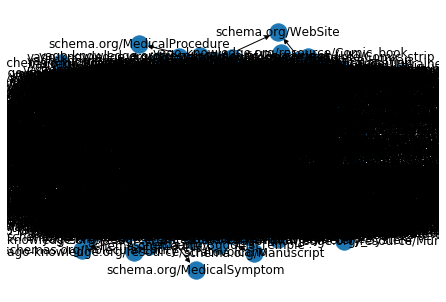

In [4]:
#nx.draw_kamada_kawai(small_g,  with_labels = True) #, node_size=5)
#plt.show()


nx.nx_agraph.write_dot(g, './output/taxonomy_small.dot' )